In [1]:
from time import time
import torch
import numpy as np
import torch.nn.functional as F
from typing import List
from collections import OrderedDict
from torch import nn
from torch import asin
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
from layers import LinearArcsine, RandomFeatureMap, ArcsinNN, RepresentArcsineNN, ApproxArcsineNN

In [4]:
indicators = [lambda x: (x>0).float(), lambda x: ((torch.tanh(x) + 1)/2).float(), lambda x: (torch.atan(x) * 2 / np.pi + 1).float(), lambda x: torch.sigmoid(x).float(), lambda x: torch.sigmoid(10 * x).float(), lambda x: torch.sigmoid(20 * x).float()]
indicator_names = ['indicator', 'tanh', 'arctan', 'sigmoid(x)', 'sigmoid(10x)', 'sigmoid(20x)']

In [29]:
"""
Error of approximation v.s. output dimension
input dim = output dim
"""
N = 100
dims = np.arange(250,10100,250)
error = [{}]*len(indicators)
rng = torch.Generator(device=device)
rng.manual_seed(20220815)
for i, indicator in enumerate(indicators):
    for d in dims:
        """
        Generate random vectors
        """
        X = F.normalize(torch.randn(size=(N,d), generator=rng, device = device), dim=1)
        Y = F.normalize(torch.randn(size=(N,d), generator=rng, device = device), dim=1)
        M = torch.asin(torch.matmul(X, Y.T))
        
        f = RandomFeatureMap(in_features=d, device=device, indicator=indicator).float()
        error[i][d] = torch.norm(M - torch.matmul(f(X), f(Y).T) / (2 * d / np.pi))/(N**2)

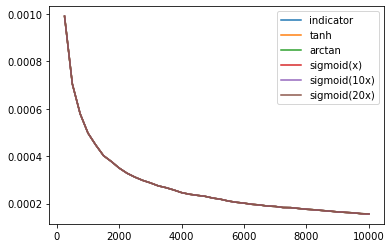

In [35]:
for i, indicator in enumerate(indicators):
    plt.plot(dims, [error[i][d].cpu().float() for d in dims])
plt.legend(indicator_names)

In [36]:
"""
Error of approximation v.s. output dimension
input dim fixed
"""
N = 1000
D = 250
dims = np.arange(250,10100,250)
error_2 = [{}]*len(indicators)
rng = torch.Generator(device=device)
rng.manual_seed(20220815)
"""
Generate random vectors
"""
X = F.normalize(torch.randn(size=(N,D), generator=rng, device = device), dim=1)
Y = F.normalize(torch.randn(size=(N,D), generator=rng, device = device), dim=1)
M = torch.asin(torch.matmul(X, Y.T))

for i, indicator in enumerate(indicators):
    for d in dims:
        err = 0
        for t in range(5):
            f = RandomFeatureMap(in_features=D, out_features=d, device=device).float()
            err += torch.norm(M - torch.matmul(f(X), f(Y).T) / (2 * d/ np.pi) )/(N**2)
        error_2[i][d] = err/5

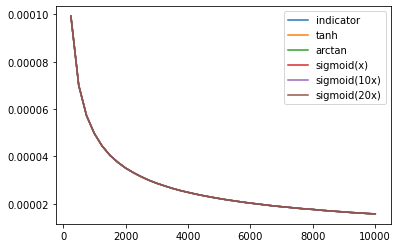

In [37]:
for i, indicator in enumerate(indicators):
    plt.plot(dims, [error_2[i][d].cpu().float() for d in dims])
plt.legend(indicator_names)

In [5]:
"""
Download data from FashionMNIST
"""
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

learning_rate = 5*1e-3
batch_size = 64
epochs = 20
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(training_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_agg = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_agg.append(loss)
    return loss_agg

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n accuracy_2: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [20]:
"""
Fix depth = 3
"""
hidden_depth = 3
width = [512, 1024, 2048, 4096]

training_time = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
accuracy = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
test_loss = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

for w in width:
    model = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[w]*hidden_depth).to(device)
    approx_scratch = ApproxArcsineNN(model).to(device)
    composite_scratch = RepresentArcsineNN(model).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
    end = time()
    training_time['origin'].append(end - start)
    acc, loss = test_loop(test_loader, model, loss_fn)
    accuracy['origin'].append(acc)
    test_loss['origin'].append(loss)

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch, loss_fn, optimizer)
    end = time()
    training_time['approx_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_scratch, loss_fn)
    accuracy['approx_scratch'].append(acc)
    test_loss['approx_scratch'].append(loss)

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch, loss_fn, optimizer)
    end = time()
    training_time['composite_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, composite_scratch, loss_fn)
    accuracy['composite_scratch'].append(acc)
    test_loss['composite_scratch'].append(loss)

    approx_retrain = ApproxArcsineNN(model).to(device)
    composite_retrain = RepresentArcsineNN(model).to(device)

    # train approx_retrain
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=approx_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain, loss_fn, optimizer)
    end = time()
    training_time['approx_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_retrain, loss_fn)
    accuracy['approx_retrain'].append(acc)
    test_loss['approx_retrain'].append(loss)

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain, loss_fn, optimizer)
    end = time()
    training_time['composite_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, composite_retrain, loss_fn)
    accuracy['composite_retrain'].append(acc)
    test_loss['composite_retrain'].append(loss)

training original model
Epoch 1
-------------------------------
loss: 2.305715  [    0/60000]
loss: 0.595073  [ 6400/60000]
loss: 0.452257  [12800/60000]
loss: 0.607140  [19200/60000]
loss: 0.593143  [25600/60000]
loss: 0.445403  [32000/60000]
loss: 0.473764  [38400/60000]
loss: 0.545338  [44800/60000]
loss: 0.505383  [51200/60000]
loss: 0.536072  [57600/60000]
Epoch 2
-------------------------------
loss: 0.463714  [    0/60000]
loss: 0.442885  [ 6400/60000]
loss: 0.384855  [12800/60000]
loss: 0.526033  [19200/60000]
loss: 0.582358  [25600/60000]
loss: 0.408807  [32000/60000]
loss: 0.417740  [38400/60000]
loss: 0.510153  [44800/60000]
loss: 0.510295  [51200/60000]
loss: 0.481781  [57600/60000]
Epoch 3
-------------------------------
loss: 0.404229  [    0/60000]
loss: 0.434288  [ 6400/60000]
loss: 0.347597  [12800/60000]
loss: 0.483472  [19200/60000]
loss: 0.532196  [25600/60000]
loss: 0.399682  [32000/60000]
loss: 0.365249  [38400/60000]
loss: 0.500309  [44800/60000]
loss: 0.491595  

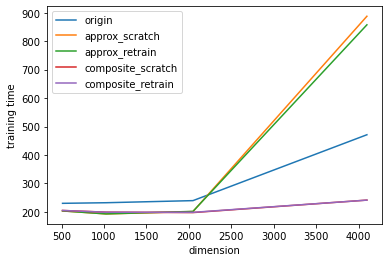

In [23]:
for key in training_time:
    plt.plot(width, training_time[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('training time')
plt.show()

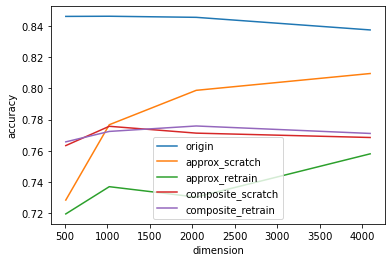

In [24]:
for key in accuracy:
    plt.plot(width, accuracy[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

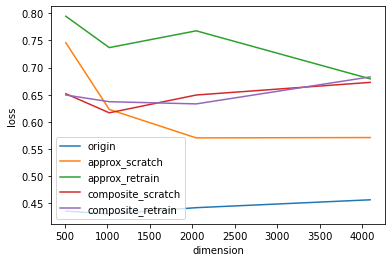

In [25]:
for key in test_loss:
    plt.plot(width, test_loss[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('loss')
plt.show()

In [26]:
"""
Fix width = 1024
"""
hidden_depth = [3,4,5,6]
width = 1024

training_time_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
accuracy_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
test_loss_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

for depth in hidden_depth:
    model_2 = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[width]*depth).to(device)
    approx_scratch_2 = ApproxArcsineNN(model_2).to(device)
    composite_scratch_2 = RepresentArcsineNN(model_2).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model_2, loss_fn, optimizer)
    end = time()
    training_time_2['origin'].append(end - start)
    acc, loss = test_loop(test_loader, model_2, loss_fn)
    accuracy_2['origin'].append(acc)
    test_loss_2['origin'].append(loss)

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch_2, loss_fn, optimizer)
    end = time()
    training_time_2['approx_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_scratch_2, loss_fn)
    accuracy_2['approx_scratch'].append(acc)
    test_loss_2['approx_scratch'].append(loss)

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch_2, loss_fn, optimizer)
    end = time()
    training_time_2['composite_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, composite_scratch_2, loss_fn)
    accuracy_2['composite_scratch'].append(acc)
    test_loss_2['composite_scratch'].append(loss)

    approx_retrain_2 = ApproxArcsineNN(model_2).to(device)
    composite_retrain_2 = RepresentArcsineNN(model_2).to(device)

    # train approx_retrain
    print("training approx_retrain model")
    optimizer = torch.optim.Adam(params=approx_retrain_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain_2, loss_fn, optimizer)
    end = time()
    training_time_2['approx_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_retrain_2, loss_fn)
    accuracy_2['approx_retrain'].append(acc)
    test_loss_2['approx_retrain'].append(loss)

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain_2, loss_fn, optimizer)
    end = time()
    training_time_2['composite_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, composite_retrain_2, loss_fn)
    accuracy_2['composite_retrain'].append(acc)
    test_loss_2['composite_retrain'].append(loss)

training original model
Epoch 1
-------------------------------
loss: 2.300231  [    0/60000]
loss: 0.601720  [ 6400/60000]
loss: 0.446406  [12800/60000]
loss: 0.689496  [19200/60000]
loss: 0.584937  [25600/60000]
loss: 0.516176  [32000/60000]
loss: 0.495349  [38400/60000]
loss: 0.598756  [44800/60000]
loss: 0.505564  [51200/60000]
loss: 0.526294  [57600/60000]
Epoch 2
-------------------------------
loss: 0.441713  [    0/60000]
loss: 0.495493  [ 6400/60000]
loss: 0.386710  [12800/60000]
loss: 0.513034  [19200/60000]
loss: 0.506458  [25600/60000]
loss: 0.431850  [32000/60000]
loss: 0.425252  [38400/60000]
loss: 0.562519  [44800/60000]
loss: 0.485700  [51200/60000]
loss: 0.516938  [57600/60000]
Epoch 3
-------------------------------
loss: 0.384832  [    0/60000]
loss: 0.473087  [ 6400/60000]
loss: 0.323148  [12800/60000]
loss: 0.465757  [19200/60000]
loss: 0.489508  [25600/60000]
loss: 0.414242  [32000/60000]
loss: 0.384313  [38400/60000]
loss: 0.539285  [44800/60000]
loss: 0.465858  

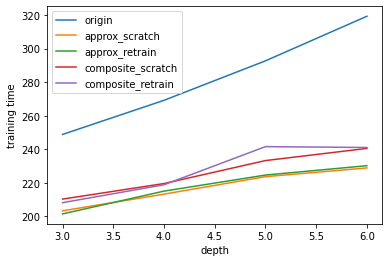

In [30]:
for key in training_time_2:
    plt.plot(hidden_depth, training_time_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('training time')
plt.show()

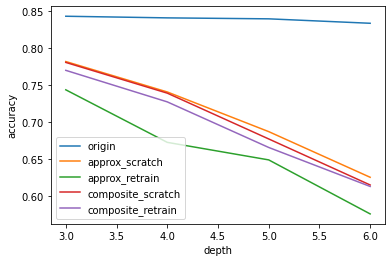

In [31]:
for key in accuracy_2:
    plt.plot(hidden_depth, accuracy_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

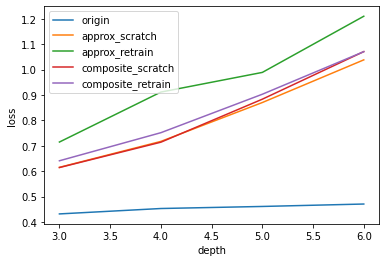

In [33]:
for key in test_loss_2:
    plt.plot(hidden_depth, test_loss_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('loss')
plt.show()

In [42]:
"""
Training loss over time
"""
depth = 5
width = 1024

model_3 = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[width]*depth).to(device)
approx_scratch_3 = ApproxArcsineNN(model_3).to(device)
composite_scratch_3 = RepresentArcsineNN(model_3).to(device)

training_loss = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

# train model
print("training original model")
optimizer = torch.optim.Adam(params=model_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['origin'] += train_loop(train_loader, model_3, loss_fn, optimizer)

print("training approx_scratch model")
optimizer = torch.optim.Adam(params=approx_scratch_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['approx_scratch'] += train_loop(train_loader, approx_scratch_3, loss_fn, optimizer)

print("training composite_scratch model")
optimizer = torch.optim.Adam(params=composite_scratch_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['composite_scratch'] += train_loop(train_loader, composite_scratch_3, loss_fn, optimizer)

approx_retrain_3 = ApproxArcsineNN(model_3).to(device)
composite_retrain_3 = RepresentArcsineNN(model_3).to(device)

print("training approx_retrain model")
optimizer = torch.optim.Adam(params=approx_retrain_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['approx_retrain'] += train_loop(train_loader, approx_retrain_3, loss_fn, optimizer)

print("training composite_retrain model")
optimizer = torch.optim.Adam(params=composite_retrain_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['composite_retrain'] +=  train_loop(train_loader, composite_retrain_3, loss_fn, optimizer)


training original model
Epoch 1
-------------------------------
loss: 2.303284  [    0/60000]
loss: 0.796624  [ 6400/60000]
loss: 0.516803  [12800/60000]
loss: 0.839117  [19200/60000]
loss: 0.645899  [25600/60000]
loss: 0.556334  [32000/60000]
loss: 0.593760  [38400/60000]
loss: 0.636858  [44800/60000]
loss: 0.572569  [51200/60000]
loss: 0.622607  [57600/60000]
Epoch 2
-------------------------------
loss: 0.502766  [    0/60000]
loss: 0.560027  [ 6400/60000]
loss: 0.380391  [12800/60000]
loss: 0.673890  [19200/60000]
loss: 0.657071  [25600/60000]
loss: 0.526992  [32000/60000]
loss: 0.520077  [38400/60000]
loss: 0.585495  [44800/60000]
loss: 0.564500  [51200/60000]
loss: 0.572184  [57600/60000]
Epoch 3
-------------------------------
loss: 0.472443  [    0/60000]
loss: 0.534871  [ 6400/60000]
loss: 0.345406  [12800/60000]
loss: 0.635742  [19200/60000]
loss: 0.632434  [25600/60000]
loss: 0.459517  [32000/60000]
loss: 0.500651  [38400/60000]
loss: 0.567645  [44800/60000]
loss: 0.543434  

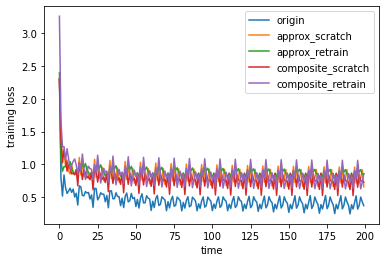

In [43]:
for key in test_loss_2:
    plt.plot(np.arange(len(training_loss[key])), training_loss[key], label = key)
plt.legend()
plt.xlabel('time')
plt.ylabel('training loss')
plt.show()

In [7]:
"""
Experiments with different "indicator" functions:
"""
depth = 3
width = 1024

training_time_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}
accuracy_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}
test_loss_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}


for indicator, name in zip(indicators, indicator_names):
    model_4 = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[width]*depth).to(device)
    approx_scratch_4 = ApproxArcsineNN(model_4, indicator = indicator).to(device)
    composite_scratch_4 = RepresentArcsineNN(model_4, indicator = indicator).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model_4, loss_fn, optimizer)
    end = time()
    training_time_4['origin'][name] = end - start
    acc, loss = test_loop(test_loader, model_4, loss_fn)
    accuracy_4['origin'][name] = acc
    test_loss_4['origin'][name] = loss

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch_4, loss_fn, optimizer)
    end = time()
    training_time_4['approx_scratch'][name] = end - start
    acc, loss = test_loop(test_loader, approx_scratch_4, loss_fn)
    accuracy_4['approx_scratch'][name] = acc
    test_loss_4['approx_scratch'][name] = loss

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch_4, loss_fn, optimizer)
    end = time()
    training_time_4['composite_scratch'][name] = end - start
    acc, loss = test_loop(test_loader, composite_scratch_4, loss_fn)
    accuracy_4['composite_scratch'][name] = acc
    test_loss_4['composite_scratch'][name] = loss

    approx_retrain_4 = ApproxArcsineNN(model_4, indicator=indicator).to(device)
    composite_retrain_4 = RepresentArcsineNN(model_4, indicator=indicator).to(device)

    # train approx_retrain
    print("training approx_retrain model")
    optimizer = torch.optim.Adam(params=approx_retrain_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain_4, loss_fn, optimizer)
    end = time()
    training_time_4['approx_retrain'][name] = end - start
    acc, loss = test_loop(test_loader, approx_retrain_4, loss_fn)
    accuracy_4['approx_retrain'][name] = acc
    test_loss_4['approx_retrain'][name] = loss

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain_4, loss_fn, optimizer)
    end = time()
    training_time_4['composite_retrain'][name] = end - start
    acc, loss = test_loop(test_loader, composite_retrain_4, loss_fn)
    accuracy_4['composite_retrain'][name] = acc
    test_loss_4['composite_retrain'][name] = loss

training original model
Epoch 1
-------------------------------
loss: 2.305407  [    0/60000]
loss: 0.640628  [ 6400/60000]
loss: 0.495219  [12800/60000]
loss: 0.607022  [19200/60000]
loss: 0.610760  [25600/60000]
loss: 0.440371  [32000/60000]
loss: 0.505037  [38400/60000]
loss: 0.601927  [44800/60000]
loss: 0.511077  [51200/60000]
loss: 0.517632  [57600/60000]
Epoch 2
-------------------------------
loss: 0.469724  [    0/60000]
loss: 0.487994  [ 6400/60000]
loss: 0.376306  [12800/60000]
loss: 0.507625  [19200/60000]
loss: 0.572943  [25600/60000]
loss: 0.452533  [32000/60000]
loss: 0.419776  [38400/60000]
loss: 0.543597  [44800/60000]
loss: 0.509664  [51200/60000]
loss: 0.479337  [57600/60000]
Epoch 3
-------------------------------
loss: 0.409178  [    0/60000]
loss: 0.438544  [ 6400/60000]
loss: 0.342666  [12800/60000]
loss: 0.449983  [19200/60000]
loss: 0.534407  [25600/60000]
loss: 0.408284  [32000/60000]
loss: 0.365170  [38400/60000]
loss: 0.535433  [44800/60000]
loss: 0.515260  

In [8]:
accuracy_4

{'origin': {'indicator': 0.8482,
  'tanh': 0.8466,
  'arctan': 0.8444,
  'sigmoid(x)': 0.8457,
  'sigmoid(10x)': 0.842,
  'sigmoid(20x)': 0.8456},
 'approx_scratch': {'indicator': 0.7695,
  'tanh': 0.8532,
  'arctan': 0.8573,
  'sigmoid(x)': 0.8594,
  'sigmoid(10x)': 0.8073,
  'sigmoid(20x)': 0.7753},
 'approx_retrain': {'indicator': 0.7381,
  'tanh': 0.8372,
  'arctan': 0.8517,
  'sigmoid(x)': 0.8477,
  'sigmoid(10x)': 0.7971,
  'sigmoid(20x)': 0.7634},
 'composite_scratch': {'indicator': 0.7735,
  'tanh': 0.7921,
  'arctan': 0.7699,
  'sigmoid(x)': 0.8024,
  'sigmoid(10x)': 0.7851,
  'sigmoid(20x)': 0.7441},
 'composite_retrain': {'indicator': 0.773,
  'tanh': 0.7773,
  'arctan': 0.7715,
  'sigmoid(x)': 0.7978,
  'sigmoid(10x)': 0.771,
  'sigmoid(20x)': 0.7605}}